In [7]:
"""
05_xgboost_model.py

Purpose:
--------
This script trains a gradient boosting regression model (XGBoost) to predict user engagement
based on a simulated A/B test dataset. It serves as a complementary analysis to the GEE model
by capturing nonlinear relationships and feature interactions.

Key Steps:
----------
- Load and preprocess engagement data
- Aggregate pre-treatment behavior as a control covariate
- Train/test split for model evaluation
- Fit XGBoost model to predict engagement
- Evaluate model using RMSE
- Save feature importances plot to `../figures/`

Notes:
------
This model is for demonstration only and complements the GEE results by showing ML-based
feature contributions (e.g., treatment effect, user type, device). Not intended for causal inference.
"""

'\n05_xgboost_model.py\n\nPurpose:\n--------\nThis script trains a gradient boosting regression model (XGBoost) to predict user engagement\nbased on a simulated A/B test dataset. It serves as a complementary analysis to the GEE model\nby capturing nonlinear relationships and feature interactions.\n\nKey Steps:\n----------\n- Load and preprocess engagement data\n- Aggregate pre-treatment behavior as a control covariate\n- Train/test split for model evaluation\n- Fit XGBoost model to predict engagement\n- Evaluate model using RMSE\n- Save feature importances plot to `../figures/`\n\nNotes:\n------\nThis model is for demonstration only and complements the GEE results by showing ML-based\nfeature contributions (e.g., treatment effect, user type, device). Not intended for causal inference.\n'

In [8]:
# Load libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import os

In [9]:
# Load in dataset
DATA_PATH = os.path.join("..", "data", "simulated_user_behavior.csv")

# Load data
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Expected dataset not found at: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Confirmed: data loaded")
print(df.head())

Confirmed: data loaded
   user_id  day  age  is_premium  device region signup_channel  power_user  \
0        0    0   46           0  mobile   APAC        organic           1   
1        0    1   46           0  mobile   APAC        organic           1   
2        0    2   46           0  mobile   APAC        organic           1   
3        0    3   46           0  mobile   APAC        organic           1   
4        0    4   46           0  mobile   APAC        organic           1   

   is_female  treatment  post  post_treated  engagement  prior_engagement  
0          0          0     0             0    2.078719          3.730117  
1          0          0     0             0    1.373123          3.730117  
2          0          0     0             0    3.510399          3.730117  
3          0          0     0             0    2.622221          3.730117  
4          0          0     0             0    3.729853          3.730117  


In [10]:
# Intervention flag
intervention_day = 30
df["post"] = (df["day"] >= intervention_day).astype(int)
df["post_treated"] = df["post"] * df["treatment"]

# Simulate gender
df["is_female"] = np.random.binomial(1, 0.5, len(df))

# Ensure user_id is int for clean merge
df["user_id"] = df["user_id"].astype(int)

# Compute user-level pre-period average engagement
prior_engagement = (
    df[df["day"] < intervention_day]
    .groupby("user_id")["engagement"]
    .mean()
    .rename("prior_engagement")
)

# Merge into main DF if not already present
if "prior_engagement" not in df.columns:
    df = df.merge(prior_engagement, on="user_id", how="left")

# Drop users with no pre-period data
df = df.dropna(subset=["prior_engagement"])

# Drop users with no pre-period data
df = df.dropna(subset=["prior_engagement"])
print("Confirmed: prior_engagement merged. Shape after dropping nulls:", df.shape)

Confirmed: prior_engagement merged. Shape after dropping nulls: (300000, 14)


In [11]:
# Define features
features = [
    "post", "treatment", "post_treated", "age", "is_female",
    "prior_engagement", "is_premium", "power_user"
]
X = df[features]
y = df["engagement"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit XGBoost model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Confirmed: RMSE on test set: {rmse:.3f}")

Confirmed: RMSE on test set: 1.085


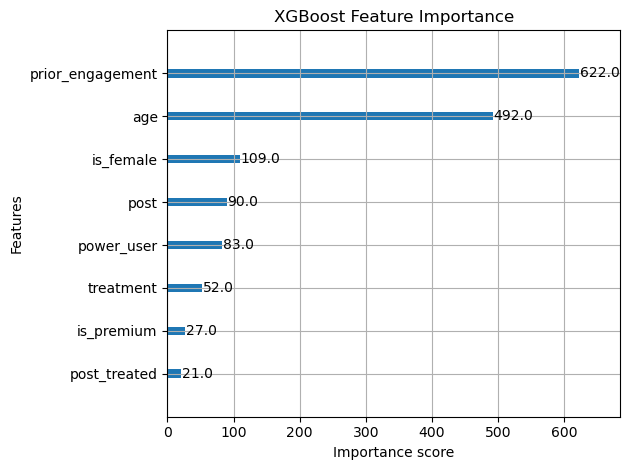

In [12]:
# Plot feature importances
xgb.plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()